<a href="https://colab.research.google.com/github/Niloy-Chakraborty/Stock-Price-Prediction-using-Deep-Learning/blob/main/Stock_Prediction_LIXIL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook for LIXIL Stock Price Prediction

In [1]:
"""
Created on Tue Sep 14 20:01:37 2021
@author = Chakraborty
"""

'\nCreated on Tue Sep 14 20:01:37 2021\n@author = Chakraborty\n'

In [ ]:
# ! pip install yfinance

### Import Dependencies

In [3]:
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, median_absolute_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn import preprocessing

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from tensorflow.keras import optimizers

import yfinance as yf

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline

In [4]:
# Connect to Google Colab.  If using Jupyter, then comment this part
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/GROHE_NILOY/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/GROHE_NILOY


### Load the Data

#### Load Data from api from data source

In [5]:
# Download data as Dataframe
# Code for LIXIL = JSGRY
# Data Source = Yahoo finace: https://finance.yahoo.com/

company_code = "JSGRY"
df = yf.download(company_code, start='2010-10-15',end='2021-09-10',progress=False,)

#### Load Data from downloaded csv from data source

In [6]:
# # Load the data in DataFrame format
# # Data Source = https://finance.yahoo.com/quote/JSGRY/

# data_path = "Data/Lixil_2010_2021.csv"
# df = pd.read_csv(data_path)

### Analyze the Data

In [7]:
# print a first few rows
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-10-15,36.750000,36.750000,36.750000,36.750000,36.750000,200
2010-10-18,36.750000,36.750000,36.750000,36.750000,36.750000,0
2010-10-21,38.450001,38.450001,38.450001,38.450001,38.450001,200
2010-10-22,38.450001,38.450001,38.450001,38.450001,38.450001,0
2010-12-23,43.180000,43.180000,43.180000,43.180000,43.180000,200
2010-12-27,43.180000,43.180000,43.180000,43.180000,43.180000,0
2010-12-29,43.450001,43.450001,43.450001,43.450001,43.450001,500
2010-12-30,43.450001,43.450001,43.450001,43.450001,43.450001,0
2011-01-03,43.799999,43.799999,43.799999,43.799999,43.799999,500


So, there is no entry for saturdays and sundays. Also, stock market remains closed on public holidays. This justifies why there is less number of entries.

In [8]:
# Check the shape
df.shape

(2458, 6)

In [9]:
# Check the data type and info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2458 entries, 2010-10-15 to 2021-09-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2458 non-null   float64
 1   High       2458 non-null   float64
 2   Low        2458 non-null   float64
 3   Close      2458 non-null   float64
 4   Adj Close  2458 non-null   float64
 5   Volume     2458 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 134.4 KB


So, we have 10 years data and all data is numeric. Lets check if we have any missing values...

In [10]:
# Check missing values
print('Number of missing values in the dataset:', df.isnull().sum())
print('Percentage of missing values in the dataset:', df.isnull().sum().sum()*100/(df.shape[0]*df.shape[1]))

Number of missing values in the dataset: Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Percentage of missing values in the dataset: 0.0


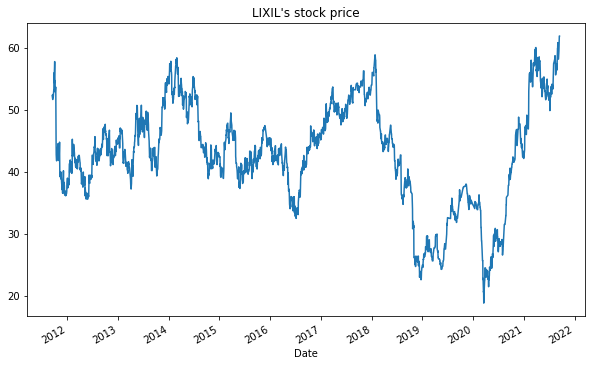

In [11]:
# Plot the data for past years for the closing value
ticker = yf.Ticker(company_code)
aapl_df = ticker.history(period="10y")
aapl_df['Close'].plot(title="LIXIL's stock price", figsize=(10, 6))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36b44f5050>,
      dtype=object)

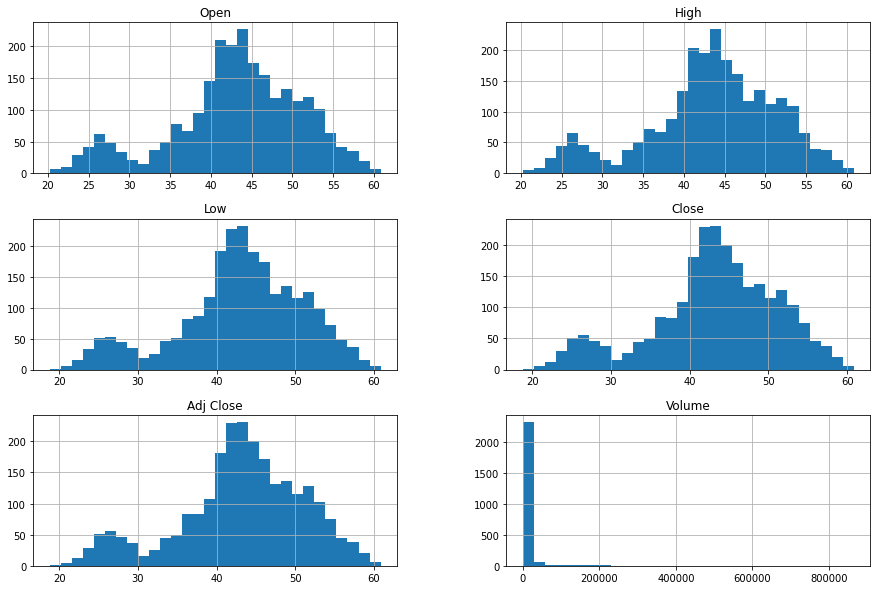

In [12]:
# Analyse the distribution of the data
df.hist(bins=30, figsize=(15, 10))

In [13]:
# check the mean,min,max and percentile values of the data
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000,2458.000000
mean,43.173389,43.323710,43.021412,43.176542,43.176542,10159.641985
std,8.019118,8.028099,8.008578,8.022930,8.022930,39912.520115
min,20.230000,20.230000,18.799999,18.799999,18.799999,0.000000
25%,39.534999,39.680000,39.354999,39.480000,39.480000,600.000000
50%,43.684999,43.889999,43.490002,43.730000,43.730000,1800.000000
75%,48.835000,48.980000,48.634999,48.805001,48.805001,4775.000000
max,60.830002,60.830002,60.830002,60.830002,60.830002,864600.000000


Mean is 43.17.  All time `High` is 60.83. All time `Low` is 18.79. `Volume` would refer to the number of shares of a security traded between its daily open and close. Here IQR of Volume fall between 600 to 4775. However, 864600 is observed as a max value.

### Data Cleaning & Normalization

In [14]:
# Looks like 	Adj Close and Close are exactly same, so lets drop this column

df = df.drop("Adj Close",axis=1)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-10-15,36.750000,36.750000,36.750000,36.750000,200
2010-10-18,36.750000,36.750000,36.750000,36.750000,0
2010-10-21,38.450001,38.450001,38.450001,38.450001,200
2010-10-22,38.450001,38.450001,38.450001,38.450001,0
2010-12-23,43.180000,43.180000,43.180000,43.180000,200


Now lets normalize the data. As we have seen before, there are values far beyond the IQR, and it could impact the model's prediction. So lets use RobustScaler which, by definition, is robust to the outliers.

In [15]:
# Robust scaling
data = df.values
scaler = preprocessing.RobustScaler()

scaled_data = scaler.fit_transform(data)

### Data Pre-processing

#### 1. Data Window Creation

For this task, lets take data from last 50 past days (history_points), and try to predict the closing stock price for the next day. 

In [16]:
history_points = 50
# using the last {history_points} open close high low volume data points, predict the next close value

lixil_histories_normalised = []
close_values_normalised = []
close_values= []

def createWindows(scaled_data,data):
  """
  Function to create windows
  """

  for i in range(len(scaled_data) - history_points):
    data_x = scaled_data[i:i + history_points].copy()
    lixil_histories_normalised.append(data_x)

  for i in range(len(scaled_data) - history_points):
    data_y = scaled_data[:, 3][i + history_points].copy()  
    close_values_normalised.append(data_y)


  for i in range(len(data) - history_points):
    data_y_unscaled = data[:, 3][i + history_points].copy()
    close_values.append(data_y_unscaled)

  return np.array(lixil_histories_normalised),np.array(close_values_normalised), np.array(close_values)



lixil_histories, close_values_normalised, unscaled_y = createWindows(scaled_data,data)
close_values_normalised = np.expand_dims(close_values_normalised, -1)
unscaled_y = np.expand_dims(unscaled_y, -1)




In [17]:
# Create an normalizer object for test purpose.
y_normaliser = preprocessing.RobustScaler()
y_normaliser.fit(unscaled_y)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

#### Train-test split

In [18]:
# Define the split ratio
test_split = 0.75

In [19]:
n = int(lixil_histories.shape[0] * test_split)

lixil_train = lixil_histories[:n]
y_train = close_values_normalised[:n]

lixil_test = lixil_histories[n:]
y_test = close_values_normalised[n:]

unscaled_y_test = unscaled_y[n:]

print(lixil_train.shape)
print(lixil_test.shape)

(1806, 50, 5)
(602, 50, 5)


## A. Building a Baseline Model

#### 1. Create the Model

Here a LSTM based architecture is built as it shows promising result for sequence data (e.g. time-series), by learning the temporal relation from the data.

In [20]:
def lstmmodel():
  """
  Function to create LSTM model
  """
  lstm_input = Input(shape=(history_points, 5), name='lstm_input')
  x = LSTM(50, name='lstm_0')(lstm_input)
  x = Dropout(0.2, name='lstm_dropout_0')(x)
  x = Dense(64, name='dense_0')(x)
  x = Activation('sigmoid', name='sigmoid_0')(x)
  x = Dense(1, name='dense_1')(x)
  output = Activation('linear', name='linear_output')(x)
  model = Model(inputs=lstm_input, outputs=output)

  return model

model = lstmmodel()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_input (InputLayer)      [(None, 50, 5)]           0         
_________________________________________________________________
lstm_0 (LSTM)                (None, 50)                11200     
_________________________________________________________________
lstm_dropout_0 (Dropout)     (None, 50)                0         
_________________________________________________________________
dense_0 (Dense)              (None, 64)                3264      
_________________________________________________________________
sigmoid_0 (Activation)       (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
linear_output (Activation)   (None, 1)                 0     

#### 2. Compile the Model and start Training

In [21]:
# Compile the model
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse',metrics=['mae','mse'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [22]:
# Start Training
history = model.fit(x=lixil_train, y=y_train, batch_size=64, epochs=50, shuffle=True, validation_split=0.2)


Epoch 1/50
23/23 [==============================] - 3s 30ms/step - loss: 1.7836 - mae: 1.2198 - mse: 1.7836 - val_loss: 2.0496 - val_mae: 1.3895 - val_mse: 2.0496
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.3760 - mae: 0.4981 - mse: 0.3760 - val_loss: 0.1153 - val_mae: 0.2602 - val_mse: 0.1153
Epoch 3/50
23/23 [==============================] - 0s 7ms/step - loss: 0.1498 - mae: 0.3085 - mse: 0.1498 - val_loss: 0.1245 - val_mae: 0.2942 - val_mse: 0.1245
Epoch 4/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0953 - mae: 0.2393 - mse: 0.0953 - val_loss: 0.0429 - val_mae: 0.1538 - val_mse: 0.0429
Epoch 5/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0554 - mae: 0.1778 - mse: 0.0554 - val_loss: 0.0278 - val_mae: 0.1300 - val_mse: 0.0278
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0447 - mae: 0.1628 - mse: 0.0447 - val_loss: 0.0248 - val_mae: 0.1243 - val_mse: 0.0248
Epoch 7/50
23/23 [=========

In [23]:
def plot_training(history):
    """
    Function to plot training history
    """
    print(history.history.keys())

    #  "mae"
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # "mse"
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model mse')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


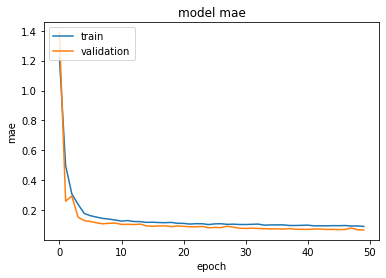

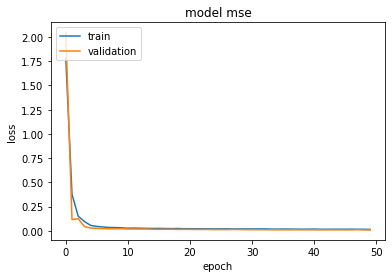

In [24]:
# plot training performance over the epochs
plot_training(history)

#### 3. Testing the Model's Performance

In [25]:
evaluation = model.evaluate(lixil_test, y_test)
print(evaluation)

19/19 [==============================] - 0s 3ms/step - loss: 0.2007 - mae: 0.3272 - mse: 0.2007
[0.20071929693222046, 0.32724133133888245, 0.20071929693222046]


In [26]:
y_predicted = model.predict(lixil_test)

# model.predict returns normalised values
# now we scale them back up using the y_scaler from before
y_predicted = y_normaliser.inverse_transform(y_predicted)

# Calculate mean suare error and R2 score 
mse = mean_squared_error(unscaled_y_test,y_predicted)
r2= r2_score(unscaled_y_test,y_predicted)

print(r2)
print(mse)

0.8777821560971132
15.479938846945739


R2 score is the goodness of Fit, and shows the model's capability to explain the variance of the actual data. So our model so far can justify 87.7% of variance. Also, we have achieved a Mean squared error of 15.47. Lets visualize the result obtained.

#### 4. Visualize our Results

In [27]:
def vizResult(unscaled_y_test,y_predicted):
  """
  Function to visualize the result of actual closing price and predicted closing price
  """
  plt.gcf().set_size_inches(10, 6, forward=True)

  start = 0
  end = -1

  real = plt.plot(unscaled_y_test[start:end], label='real closing price')
  pred = plt.plot(y_predicted[start:end], label='predicted closing price')

  plt.legend(['Real', 'Predicted'])

  plt.show()

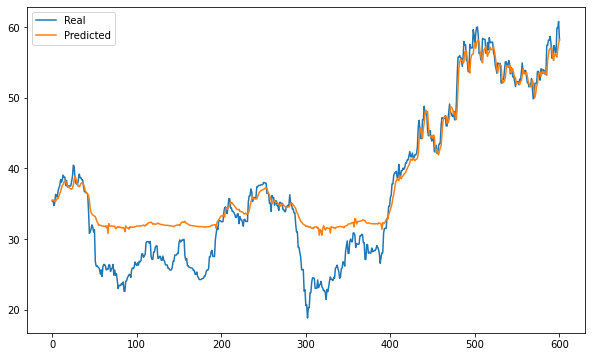

In [28]:
# visualize the results from LSTM model
vizResult(unscaled_y_test,y_predicted)

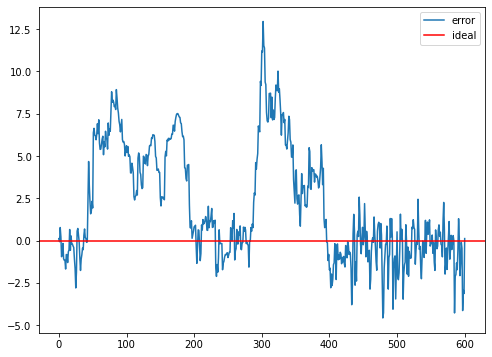

In [29]:
# Now, lets see the ideal error vs the error obtained from our model
plt.gcf().set_size_inches(8, 6, forward=True)

start = 0
end = -1

err = plt.plot(y_predicted[start:end]-unscaled_y_test[start:end], label='Error LSTM')
ideal = plt.axhline(y=0.0, color='r', linestyle='-')
plt.legend(['error', 'ideal'])

plt.show()



1.   The first plot shows the actual vs. predicted closing price. Although the prediction line is following the actual closing price at the later part,it fails to capture the trend at the begining, and the prediction curve is smooth.So, there is a room left for better prediction.
2.   The next plot dives little deeper into the error analysis. Error values change in range [+12.5,-4]. 



## B. Model Improvements

Along with daily trading data, now lets try to integrate some technical indicators. Authors in [The Application of Stock Index Price Prediction with
Neural Network](https://www.mdpi.com/2297-8747/25/3/53), have elaborated about MACD as an important Technical Indicator.

`MACD or Moving average convergence divergence: Displays trend following
characteristics and momentum characteristics.The MACD signals trend changes and indicates the start of the new trend direction. High values indicate overbought conditions, low values indicate oversold conditions.`

Also, Lets integrate SMA as a technical indicator.

`SMA or Simple Moving Averages are used to smooth the data in an array to help eliminate noise and identify trends. The SMA is literally the simplest form of a moving average. Each output value is the average of the previous n values.`



### Creation of Technical Indicators

Lets calculate MACD and SMA. The formulae are taken from [here:MACD](https://www.investopedia.com/terms/m/macd.asp) and [here:EMA](https://www.investopedia.com/ask/answers/122314/what-exponential-moving-average-ema-formula-and-how-ema-calculated.asp)

In [30]:
def calc_ema(values, time_period):
    """
    Function to calculate exponential moving average
    """
    sma = np.mean(values[:, 3])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(len(his) - time_period, len(his)):
        close = his[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

In [31]:
technical_indicators = []
for his in lixil_histories:
    
    # create sma indicator
    sma = np.mean(his[:, 3])

    # create macd indicator
    macd = calc_ema(his, 12) - calc_ema(his, 26)
    technical_indicators.append(np.array([sma,macd]))

technical_indicators = np.array(technical_indicators)

# normalize the indicators 
tech_ind_scaler = preprocessing.MinMaxScaler()
technical_indicators_normalised = tech_ind_scaler.fit_transform(technical_indicators)

#### Train-test split of Technical Indicators

In [32]:
n = int(lixil_histories.shape[0] * test_split)

tech_ind_train = technical_indicators[:n]

tech_ind_test = technical_indicators[n:]

print(tech_ind_train.shape)
print(tech_ind_test.shape)

(1806, 2)
(602, 2)


### Train Model with Technical Indicators

#### 1. Create a model

Now, lets create a new branch with Technical Indicators, and concate that with our previous LSTM architecture, and finally predict the closing price.

In [33]:

def lstm_ti_model():
  # Initialize two sets of inputs
  lstm_input = Input(shape=(history_points, 5), name='lstm_input')
  dense_input = Input(shape=(technical_indicators.shape[1],), name='tech_input')

  # the first branch works on the 1st input
  x = LSTM(50, name='lstm_0')(lstm_input)
  x = Dropout(0.2, name='lstm_dropout_0')(x)
  lstm_branch = Model(inputs=lstm_input, outputs=x)

  # the second branch opreates on the 2nd input
  y = Dense(20, name='tech_dense_0')(dense_input)
  y = Activation("relu", name='tech_relu_0')(y)
  y = Dropout(0.2, name='tech_dropout_0')(y)
  technical_indicators_branch = Model(inputs=dense_input, outputs=y)

  # combine the output from two branches
  combined = concatenate([lstm_branch.output, technical_indicators_branch.output], name='concatenate')

  z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
  z = Dense(1, activation="linear", name='dense_out')(z)

  # our model will accept the inputs of the two branches and then output a single value
  model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input], outputs=z)

  return model


model = lstm_ti_model()



#### 2. Compile and train model

In [34]:
# Compile the Model
adam = optimizers.Adam(lr=0.0005)
model.compile(optimizer=adam, loss='mse', metrics=['mae','mse'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [35]:
# Start Training with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',verbose=1,patience=15,mode='min',restore_best_weights=True)

history_new_model= model.fit(x=[lixil_train, tech_ind_train], y=y_train, batch_size=32, epochs=100, shuffle=True, validation_split=0.2,callbacks=[early_stopping])

Epoch 1/100
46/46 [==============================] - 2s 14ms/step - loss: 0.6013 - mae: 0.6317 - mse: 0.6013 - val_loss: 0.1481 - val_mae: 0.2997 - val_mse: 0.1481
Epoch 2/100
46/46 [==============================] - 0s 6ms/step - loss: 0.1023 - mae: 0.2477 - mse: 0.1023 - val_loss: 0.1059 - val_mae: 0.2568 - val_mse: 0.1059
Epoch 3/100
46/46 [==============================] - 0s 6ms/step - loss: 0.0555 - mae: 0.1799 - mse: 0.0555 - val_loss: 0.0368 - val_mae: 0.1471 - val_mse: 0.0368
Epoch 4/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0356 - mae: 0.1452 - mse: 0.0356 - val_loss: 0.0292 - val_mae: 0.1304 - val_mse: 0.0292
Epoch 5/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0285 - mae: 0.1301 - mse: 0.0285 - val_loss: 0.0292 - val_mae: 0.1307 - val_mse: 0.0292
Epoch 6/100
46/46 [==============================] - 0s 5ms/step - loss: 0.0263 - mae: 0.1245 - mse: 0.0263 - val_loss: 0.0257 - val_mae: 0.1235 - val_mse: 0.0257
Epoch 7/100
46/46 [==

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])


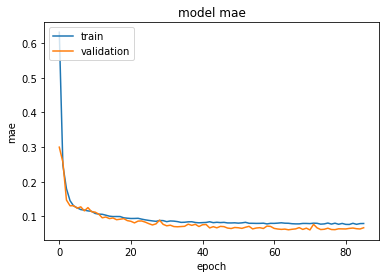

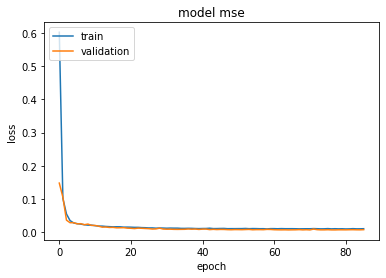

In [36]:
# plot training performance over the epochs
plot_training(history_new_model)

#### 3. Evaluate the Model with Test data

In [37]:
y_test_predicted = model.predict([lixil_test, tech_ind_test])
y_test_predicted = y_normaliser.inverse_transform(y_test_predicted)

mse = mean_squared_error(unscaled_y_test,y_test_predicted)
print(mse)

r2= r2_score(unscaled_y_test,y_test_predicted)
print(r2)

3.585369590291726
0.971692643927538


Here we can see, the model's performance is improved. Now our model's MSE value is reduced to 3.58 and also R2 value is increased to 0.9716, i.e. our prediction line can explain 97.1% variance of the actual data.

#### 4. Visualize our Results

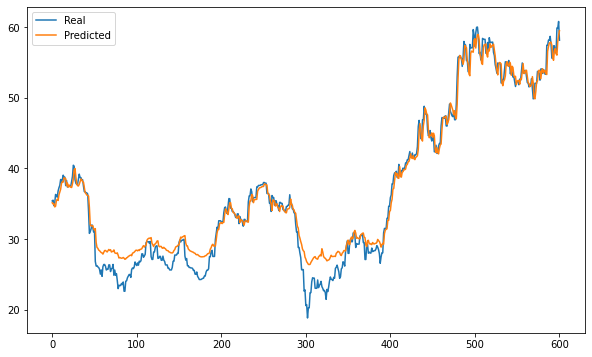

In [38]:
vizResult(unscaled_y_test,y_test_predicted)

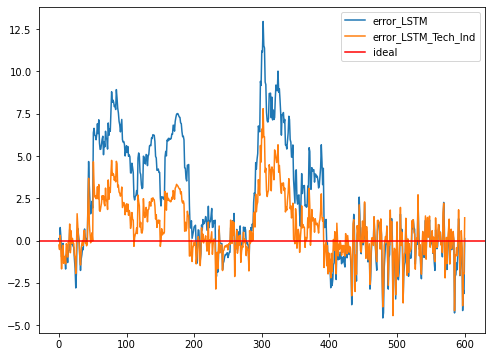

In [39]:
# Lets visualize all the error plots
plt.gcf().set_size_inches(8, 6, forward=True)

start = 0
end = -1

err = plt.plot(y_predicted[start:end]-unscaled_y_test[start:end], label='Error LSTM')
err_new = plt.plot(y_test_predicted[start:end]-unscaled_y_test[start:end], label='Error LSTM + Technical Indicator')
ideal = plt.axhline(y=0.0, color='r', linestyle='-')


plt.legend(['error_LSTM','error_LSTM_Tech_Ind', 'ideal'])

plt.show()

1.   The first plot shows the actual vs. predicted closing price. This time the prediction is closer than before.
2.   The next plot shows a comparison of the error obtained by the model in Ideal scenario, the first model (LSTM), and also the model with Technical Indicator (LSTM_Technical_Ind). LSTM_Technical_Ind shows less error. 

#### What about directional correctness?

Now finally it is also important to see the directional correctness of prediction, i.e. how many predictions are correctly showing the increasing nature (Up) between two consecutive days, and how many predictions are correctly showing the decreasing nature (Down) between two consecutive days?

In [40]:
correct_up = 0
correct_down = 0
exact  = 0
  
predicted = y_normaliser.inverse_transform(model.predict([lixil_test,tech_ind_test]))
# print(predicted.ravel())
# print(unscaled_y_test.ravel())

for i in range(1,len(list(predicted))):
  if predicted[i]-predicted[i-1]>0.00005 and unscaled_y_test[i]-unscaled_y_test[i-1]>0.00005:
    correct_up+= 1
  elif predicted[i]-predicted[i-1]<0.00005 and unscaled_y_test[i]-unscaled_y_test[i-1]<0.00005:
    correct_down+= 1
  elif predicted[i]-predicted[i-1]==0 and unscaled_y_test[i]-unscaled_y_test[i-1]==0:
    exact+=1

directional_correctness = ((correct_up + correct_down + exact) /len(unscaled_y_test))
print("Directional correctness is: ",format(directional_correctness,'.2%')) 


Directional correctness is:  51.99%


It can be seen that the captured directional correctness of the model is 52% approximately. This infers, although the model is fitting the data to a very good extent (R2 -> 97%), but the model is failing in many cases to properly identify the direction of price (upwards or downwards) for consecutive two days. For a automating traded platform, this metric is important, and hence needs to be addressed. 

## Save the Model

In [41]:
model_path = 'Models/stock_model.h5'

if not os.path.exists("Models"):
    os.makedirs("Models")
    print("Folder for storing models created Successfully !")    
model.save(model_path)

### Next Steps?


1.   Authors in [The Application of Stock Index Price Prediction with Neural Network](https://www.mdpi.com/2297-8747/25/3/53) also discussed about Macroeconomic Variable (e.g. Exchange Rate), that could have some impact of the stock price prediction.
2.   Stock price is always dynamic, and even a tweet from a important person could crash all the predictive systems. It would be also interesting to see the impact of these external factors. 

